# Wood Cutting in Furniture Industry - Capstone Assignment (REL301M) 

## Overview
This repository contains the capstone project for the course Reinforcement Learning (REL301M). Our project focuses on solving the 2D Cutting Stock Problem (CSP) in the furniture industry, optimizing wood cutting to minimize waste and maximize efficiency using heuristic and reinforcement learning approaches.

## Problem Statement
The 2D Cutting Stock Problem involves cutting rectangular demand pieces from larger wooden stock sheets while minimizing waste. This problem has significant applications in industries like furniture manufacturing, where efficient material utilization directly impacts costs and sustainability.

## Reforcement learning (Q-learning)

### 1. Libraries

In [1]:
import numpy as np
import random
import copy
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pickle
import os
import imageio

### 2. Data

In [2]:
# ============================
# DỮ LIỆU
# ============================
STOCK_WIDTH = 100
STOCK_LENGTH = 100  # stock mới là 100x100

# Một tấm gỗ (stock ban đầu)
stock_sheet = {
    "id": 1,
    "width": STOCK_WIDTH,
    "length": STOCK_LENGTH
}

# Danh sách sản phẩm
# Bàn x 2 (40×75)
# Chân bàn x 16 (4×25)
# Ghế x 4 (20×25)
products_data = [
    {"id": 1, "name": "Table",    "width": 40, "length": 75, "quantity": 2},
    {"id": 2, "name": "TableLeg", "width": 4,  "length": 25, "quantity": 16},
    {"id": 3, "name": "Chair",    "width": 20, "length": 25, "quantity": 4}
]

In [3]:
# ============================
# HÀM KIỂM TRA SÁT CẠNH
# ============================
def is_adjacent(pos1, size1, pos2, size2):
    """
    Kiểm tra xem 2 hình chữ nhật có sát cạnh nhau (share 1 biên) hay không.
    pos: (row, col)
    size: (width, height)
    """
    r1, c1 = pos1
    w1, h1 = size1
    r2, c2 = pos2
    w2, h2 = size2

    top1, bottom1, left1, right1 = r1, r1 + h1, c1, c1 + w1
    top2, bottom2, left2, right2 = r2, r2 + h2, c2, c2 + w2

    horizontal_adj = ((bottom1 > top2) and (top1 < bottom2)) and (abs(right1 - left2) == 0 or abs(right2 - left1) == 0)
    vertical_adj   = ((right1 > left2) and (left1 < right2)) and (abs(bottom1 - top2) == 0 or abs(bottom2 - top1) == 0)
    return horizontal_adj or vertical_adj


### 3. Environment 

In [4]:
# ============================
# MÔI TRƯỜNG Q-LEARNING (MULTI-STOCK)
# ============================
class MultiStockCuttingEnv:
    def __init__(self):
        self.reset()
        
    def reset(self):
        # Khởi tạo lại danh sách stocks với 1 stock ban đầu
        self.stocks = [self.create_new_stock(1)]
        # Reset sản phẩm theo products_data
        self.products = [dict(p) for p in products_data]
        # Danh sách placements: mỗi mục bao gồm {stock_id, piece_id, pos, size}
        self.placements = []
        return self.get_state()

    def create_new_stock(self, stock_id):
        return {
            "id": stock_id,
            "width": STOCK_WIDTH,
            "length": STOCK_LENGTH,
            "grid": np.full((STOCK_LENGTH, STOCK_WIDTH), -1)
        }
    
    def get_active_stock(self):
        return self.stocks[-1]
    
    def get_state(self):
        """
        State = flatten grid của stock hiện tại + danh sách quantity các sản phẩm.
        """
        active = self.get_active_stock()
        flatten_grid = active["grid"].flatten().tolist()
        q_list = [p["quantity"] for p in self.products]
        return tuple(flatten_grid + q_list)
    
    def is_done(self):
        # Xong khi không còn sản phẩm nào cần cắt
        return not any(p["quantity"] > 0 for p in self.products)
    
    def get_possible_actions(self):
        actions = []
        for p in self.products:
            if p["quantity"] > 0:
                actions.append(p["id"])
        return actions

    def step(self, action):
        """
        Thử đặt sản phẩm (action = product_id) trên stock hiện tại.
        Nếu không tìm thấy vị trí phù hợp trên stock hiện tại, tự động tạo stock mới và đặt vào đó.
        """
        product = None
        for p in self.products:
            if p["id"] == action:
                product = p
                break
        if not product:
            return self.get_state(), -1
        
        w = product["width"]
        h = product["length"]
        
        # Lấy stock hiện tại
        active = self.get_active_stock()
        placed, pos_placed = self.try_place_on_stock(active, action, w, h)
        
        # Nếu không đặt được trên stock hiện tại, tạo stock mới và đặt lại
        if not placed:
            new_id = self.stocks[-1]["id"] + 1
            new_stock = self.create_new_stock(new_id)
            self.stocks.append(new_stock)
            placed, pos_placed = self.try_place_on_stock(new_stock, action, w, h)
            # Nếu vẫn không đặt được, trả penalty
            if not placed:
                return self.get_state(), -1
        
        # Nếu đặt được, cập nhật số lượng và ghi nhận placement
        product["quantity"] -= 1
        self.placements.append({
            "stock_id": self.get_active_stock()["id"],
            "piece_id": action,
            "pos": pos_placed,
            "size": (w, h)
        })
        reward = self.compute_reward(action, pos_placed, (w, h))
        return self.get_state(), reward

    def try_place_on_stock(self, stock, action, w, h):
        grid = stock["grid"]
        b_w = stock["width"]
        b_h = stock["length"]
        placed = False
        pos_placed = None
        
        # Duyệt theo thứ tự top->down, left->right
        for row in range(b_h - h + 1):
            for col in range(b_w - w + 1):
                if np.all(grid[row:row+h, col:col+w] == -1):
                    # Yêu cầu: đặt phải sát ít nhất 1 cạnh của stock
                    if not ((row == 0) or (col == 0) or (row + h == b_h) or (col + w == b_w)):
                        continue
                    grid[row:row+h, col:col+w] = action
                    placed = True
                    pos_placed = (row, col)
                    break
            if placed:
                break
        return placed, pos_placed

    def compute_reward(self, piece_id, pos, size):
        """
        Tính reward theo quy tắc:
          (a) Đối với bàn (ID=1):
              - Lần đầu: +10 nếu đặt ở góc của stock, else +1.
              - Lần thứ hai: +8 nếu sát bàn đầu và sát cạnh stock, else +1.
          (b) Sản phẩm khác: +5 nếu sát cạnh stock hoặc sát 1 miếng đã đặt, else +1.
        """
        if piece_id == 1:
            placed_tables = [p for p in self.placements if p["piece_id"] == 1]
            count_table = len(placed_tables)
            if count_table == 1:
                # Bàn đầu: kiểm tra góc của stock hiện tại
                active = self.get_active_stock()
                corners = [
                    (0, 0),
                    (0, active["width"] - size[0]),
                    (active["length"] - size[1], 0),
                    (active["length"] - size[1], active["width"] - size[0])
                ]
                if pos in corners:
                    return 10
                else:
                    return 1
            elif count_table == 2:
                first_table = placed_tables[0]
                sat_first = is_adjacent(pos, size, first_table["pos"], first_table["size"])
                row, col = pos
                w_, h_ = size
                active = self.get_active_stock()
                touches_board = (row == 0) or (col == 0) or (row + h_ == active["length"]) or (col + w_ == active["width"])
                if sat_first and touches_board:
                    return 8
                else:
                    return 1
            else:
                return self.reward_for_other(pos, size)
        else:
            return self.reward_for_other(pos, size)
    
    def reward_for_other(self, pos, size):
        row, col = pos
        w, h = size
        active = self.get_active_stock()
        if (row == 0) or (col == 0) or (row + h == active["length"]) or (col + w == active["width"]):
            return 5
        for p in self.placements:
            if p["pos"] == pos and p["size"] == size:
                continue
            if is_adjacent(pos, size, p["pos"], p["size"]):
                return 5
        return 1

    def leftover_penalty(self):
        # Tổng leftover trên tất cả các stock
        total_leftover = sum(np.sum(stock["grid"] == -1) for stock in self.stocks)
        return -0.01 * total_leftover

    def complete_bonus(self):
        if all(p["quantity"] == 0 for p in self.products):
            return 50
        return 0

    def stock_switch_penalty(self):
        # Penalty cho mỗi stock phụ được dùng (ngoài stock đầu tiên)
        extra_stocks = len(self.stocks) - 1
        return -50 * extra_stocks

### 4. Q-Learning Methods

In [5]:
class QLearningAgent:
    def __init__(self, alpha=0.1, gamma=0.9, epsilon=0.2):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = {}  # Lưu Q(s, a)

    def get_state_key(self, state):
        return tuple(state)

    def choose_action(self, state, possible_actions):
        state_key = self.get_state_key(state)
        if random.random() < self.epsilon:
            return random.choice(possible_actions)
        q_values = [self.q_table.get((state_key, a), 0) for a in possible_actions]
        max_q = max(q_values)
        max_actions = [a for a, qv in zip(possible_actions, q_values) if qv == max_q]
        return random.choice(max_actions)

    def update(self, state, action, reward, next_state, next_possible_actions):
        state_key = self.get_state_key(state)
        next_state_key = self.get_state_key(next_state)
        current_q = self.q_table.get((state_key, action), 0)
        if next_possible_actions:
            next_q = max(self.q_table.get((next_state_key, a), 0) for a in next_possible_actions)
        else:
            next_q = 0
        new_q = current_q + self.alpha * (reward + self.gamma * next_q - current_q)
        self.q_table[(state_key, action)] = new_q

### 5. Prepare the next state

In [9]:
# ============================
# HUẤN LUYỆN (với agent được truyền vào)
# ============================
def train_q_learning(agent, num_episodes=500, max_steps=50):
    env = MultiStockCuttingEnv()
    rewards_history = []
    best_reward = -float('inf')
    best_env = None

    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        for step in range(max_steps):
            possible_actions = env.get_possible_actions()
            if not possible_actions:
                break
            action = agent.choose_action(state, possible_actions)
            next_state, r = env.step(action)
            next_possible_actions = env.get_possible_actions()
            agent.update(state, action, r, next_state, next_possible_actions)
            total_reward += r
            state = next_state
            if env.is_done():
                break
        # Cộng thêm các thành phần reward cuối episode
        total_reward += env.leftover_penalty()
        total_reward += env.complete_bonus()
        total_reward += env.stock_switch_penalty()
        rewards_history.append(total_reward)
        if total_reward > best_reward:
            best_reward = total_reward
            best_env = copy.deepcopy(env)
        print(f"Episode {episode+1}: Total Reward = {total_reward}")
        
    return best_env, rewards_history

# ============================
# LƯU VÀ TẢI MODEL (Q-TABLE)
# ============================
def save_q_table(agent, filename="q_table.pkl"):
    with open(filename, "wb") as f:
        pickle.dump(agent.q_table, f)
    print(f"Q-table saved to {filename}")

def load_q_table(agent, filename="q_table.pkl"):
    if os.path.exists(filename):
        with open(filename, "rb") as f:
            agent.q_table = pickle.load(f)
        print(f"Q-table loaded from {filename}")
    else:
        print(f"No Q-table file found at {filename}. Training from scratch.")


# ============================
# TÍNH TOÁN DIỆN TÍCH
# ============================
def compute_areas(env):
    total_area = sum(stock["width"] * stock["length"] for stock in env.stocks)
    used_area = sum(p["size"][0] * p["size"][1] for p in env.placements)
    waste_area = total_area - used_area
    return total_area, used_area, waste_area

# ============================
# IN BẢNG TÓM TẮT
# ============================
def print_best_solution_summary(env):
    print("\nSummary of Best Fit Cutting:")
    print("+----------+----------+--------------+------------+")
    print("| Stock ID | Piece ID | Dimensions   | Position   |")
    print("+----------+----------+--------------+------------+")
    for placement in env.placements:
        stock_id = placement["stock_id"]
        piece_id = placement["piece_id"]
        w, h = placement["size"]
        row, col = placement["pos"]
        dim_str = f"{w}x{h}"
        pos_str = f"({row},{col})"
        print(f"| {stock_id:<8} | {piece_id:<8} | {dim_str:<12} | {pos_str:<10} |")
    print("+----------+----------+--------------+------------+")

# ============================
# VẼ BIỂU ĐỒ REWARD
# ============================
def plot_training_rewards(rewards):
    episodes = range(1, len(rewards)+1)
    plt.figure(figsize=(8,4))
    plt.plot(episodes, rewards, marker='o', color='b')
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Q-Learning Rewards (Multi-Stock Cutting)")
    plt.grid(True)
    plt.show()

# ============================
# TRỰC QUAN HÓA KẾT QUẢ
# ============================
def visualize_best_solution(env):
    num_stocks = len(env.stocks)
    fig, axs = plt.subplots(1, num_stocks, figsize=(5*num_stocks, 6))
    if num_stocks == 1:
        axs = [axs]
    for ax, stock in zip(axs, env.stocks):
        ax.set_title(f"Stock {stock['id']}")
        ax.set_xlim(0, stock["width"])
        ax.set_ylim(0, stock["length"])
        ax.grid(True, linewidth=0.5)
        ax.imshow(np.full((stock["length"], stock["width"]), 1), cmap='gray', vmin=0, vmax=1)
        colors = ["#FF5733", "#33FF57", "#3357FF", "#F4C724", "#A833FF", "#33FFF5", "#FF33A8"]
        # Vẽ các placement trên stock này
        for p in env.placements:
            if p["stock_id"] == stock["id"]:
                color = colors[(p["piece_id"] - 1) % len(colors)]
                pos = p["pos"]
                size = p["size"]
                rect = patches.Rectangle((pos[1], pos[0]), size[0], size[1],
                                         linewidth=1.5, edgecolor="black",
                                         facecolor=color, alpha=0.8)
                ax.add_patch(rect)
    plt.tight_layout()
    plt.show()

# ============================
# TEST EPISODE
# ============================
def simulate_episode(agent, max_steps=50):
    env = MultiStockCuttingEnv()
    state = env.reset()
    total_reward = 0
    while not env.is_done():
        possible_actions = env.get_possible_actions()
        if not possible_actions:
            break
        action = agent.choose_action(state, possible_actions)
        next_state, r = env.step(action)
        total_reward += r
        state = next_state
    total_reward += env.leftover_penalty()
    total_reward += env.complete_bonus()
    total_reward += env.stock_switch_penalty()
    return env, total_reward

### 6. Main

Q-table loaded from q_table.pkl
Loaded Q-table. Running test episode...


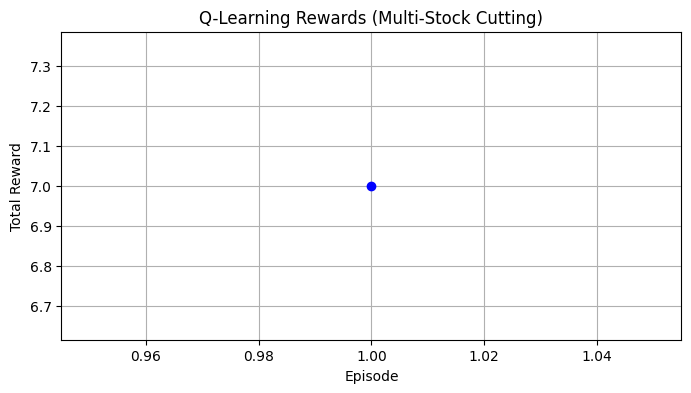


Total Area = 20000
Used Area  = 9600
Waste Area = 10400

Summary of Best Fit Cutting:
+----------+----------+--------------+------------+
| Stock ID | Piece ID | Dimensions   | Position   |
+----------+----------+--------------+------------+
| 1        | 1        | 40x75        | (0,0)      |
| 1        | 2        | 4x25         | (0,40)     |
| 1        | 1        | 40x75        | (0,44)     |
| 1        | 2        | 4x25         | (0,84)     |
| 1        | 2        | 4x25         | (0,88)     |
| 1        | 2        | 4x25         | (0,92)     |
| 1        | 3        | 20x25        | (75,0)     |
| 1        | 3        | 20x25        | (75,20)    |
| 1        | 3        | 20x25        | (75,40)    |
| 1        | 2        | 4x25         | (0,96)     |
| 1        | 3        | 20x25        | (75,60)    |
| 1        | 2        | 4x25         | (25,96)    |
| 1        | 2        | 4x25         | (50,96)    |
| 1        | 2        | 4x25         | (75,80)    |
| 1        | 2        | 4x25 

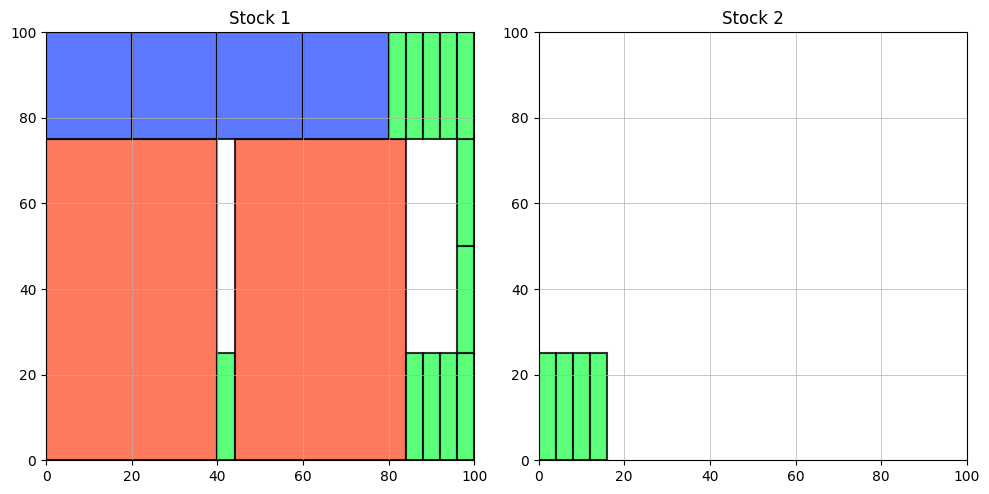

In [10]:
# ============================
# MAIN
# ============================
def main():
    agent = QLearningAgent(alpha=0.1, gamma=0.9, epsilon=0.2)
    model_file = "q_table.pkl"
    
    if os.path.exists(model_file):
        load_q_table(agent, model_file)
        print("Loaded Q-table. Running test episode...")
        best_env, test_reward = simulate_episode(agent, max_steps=50)
        rewards_history = [test_reward]
    else:
        print("No saved Q-table found. Training agent...")
        best_env, rewards_history = train_q_learning(agent=agent, num_episodes=500, max_steps=50)
        save_q_table(agent, model_file)
    
    plot_training_rewards(rewards_history)
    
    if best_env is not None:
        total_area, used_area, waste_area = compute_areas(best_env)
        print(f"\nTotal Area = {total_area}")
        print(f"Used Area  = {used_area}")
        print(f"Waste Area = {waste_area}")
        print_best_solution_summary(best_env)
        visualize_best_solution(best_env)

if __name__ == "__main__":
    main()